# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [4]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162989 sha256=72e7b3e1d8298d0454edbb626c0a7adba35f7aa2334c09f311bbfc2e10dfb7d0
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [5]:
# Basic python libraries
import numpy as np
import pandas as pd

# Python libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD
from collections import defaultdict

# For implementing cross-validation
from surprise.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [6]:
# Import the Dataset
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ratings_Electronics.csv")


In [7]:
# Check the data was uploaded
data.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [8]:
# Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
data.rename(columns = {'AKM1MP6P0OYPR':'user_id', '0132793040':'prod_id', "5.0":"rating"}, inplace = True)
data.head()


,user_id,prod_id,rating,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [9]:
# Drop the column timestamp
data.drop(['1365811200',], axis =1, inplace = True)
data.head()


,user_id,prod_id,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [10]:
# Copy the data to another DataFrame called df
df= data.copy()

In [11]:
#We check the structure of our dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [12]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [13]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [14]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [15]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [16]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [17]:
# Check the number of rows and columns and provide observations
df_final.info()


<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Write your observations here:**


1.- We see how the number of observations were reduced from  7,824,482 to 65,290 observations.

2.- We also see there are not null values.

3.- We have 3 columns:

user_id is object type

prod_id is object type

rating is float type

### **Data types**

In [18]:
# Check Data types and provide observations
print(df_final.dtypes)

user_id     object
prod_id     object
rating     float64
dtype: object


**Write your observations here:**

The data types are as follow:

user_id is object type


prod_id is object type


rating is float type

We might have to change the data types of user_id and prod_id to string or even integer in the case of prod_id for better manage.

### **Checking for missing values**

In [19]:
# Check for missing values present and provide observations
missing_values = df_final.isnull().sum()

# Print the number of missing values in each column
print("Missing values in each column:")
print(missing_values)


Missing values in each column:
user_id    0
prod_id    0
rating     0
dtype: int64


**Write your observations here:**

We don't have any missing values.

### **Summary Statistics**

In [20]:
# Summary statistics of 'rating' variable and provide observations
df_final.describe().T


,count,mean,std,min,25%,50%,75%,max
rating,65290.0,4.294808,0.988915,1.0,4.0,5.0,5.0,5.0


**Write your observations here:**

We have our total count of 65290 observations.

The products are very high ranked.
Half of the products are rated with 5.0 and 1/4 of the products with 4.0.

The minimum value for a rating is 1.0 and the maximum value el 5.0

The average(mean) value is 4.294808

Standar deviation is 0.988915



### **Checking the rating distribution**

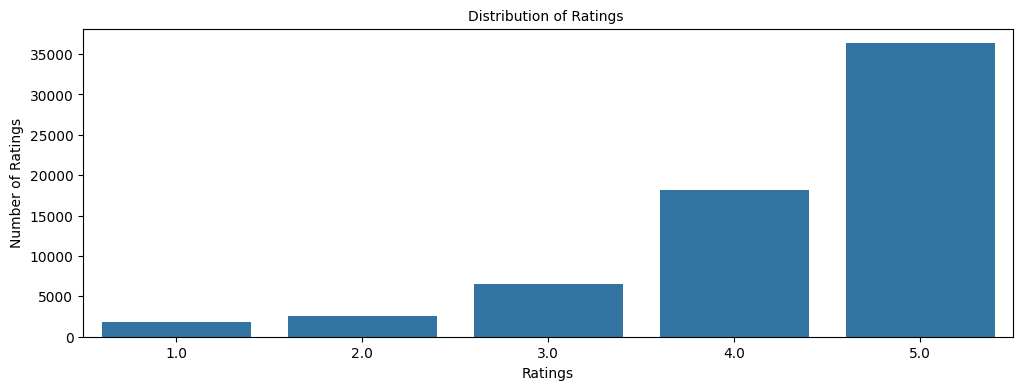

In [21]:
# Create the bar plot and provide observations
plt.figure(figsize = (12, 4))
sns.countplot(x="rating", data=df_final)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

**Write your observations here:**

The distribution is squad to the left.

The highest count of ratings are 4 and 5.

There are few ratings for class 3 and about 2000 observation ratings with the 2 and 1 classes.

### **Checking the number of unique users and items in the dataset**

In [22]:
# Number of total rows in the data and number of unique user id and product id in the data:

# Total rows
total_rows = df_final.shape[0]
total_rows

65290

In [23]:
# Total Unique values in user_id
df_final['user_id'].nunique()

1540

In [24]:
# Total Unique values in prod_id
df_final['prod_id'].nunique()

5689

In [25]:
5689*1540

8761060

**Write your observations here:**

1.- There are a total of 65290 rows in our dataset.

2.- There are 1540 user_id's.

3.- There are 5689 products rated.

4.- There is a possibility of having 8761060 ratings (users multiplied by products), so we see not all users have rated all products. From there we can create recommendation systems.


### **Users with the most number of ratings**

In [26]:
# Top 10 users based on the number of ratings
df_final['user_id'].value_counts().head(10)


user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: count, dtype: int64

**Write your observations here:**

The user that has given the most ratings has 295.

The range of number of ratings for the top 10 comes from 179 to 295.

ADLVFFE4VBT8 is the user with most ratings.

In [33]:
# Finding the most rated books in the dataset
df_final['prod_id'].value_counts().head(10)

prod_id
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
B00829THK0    137
B008DWCRQW    137
B002R5AM7C    128
B004CLYEDC    118
B002SZEOLG    113
Name: count, dtype: int64

Observations: Most rated book is B0088CJT4U with 206 reviews.

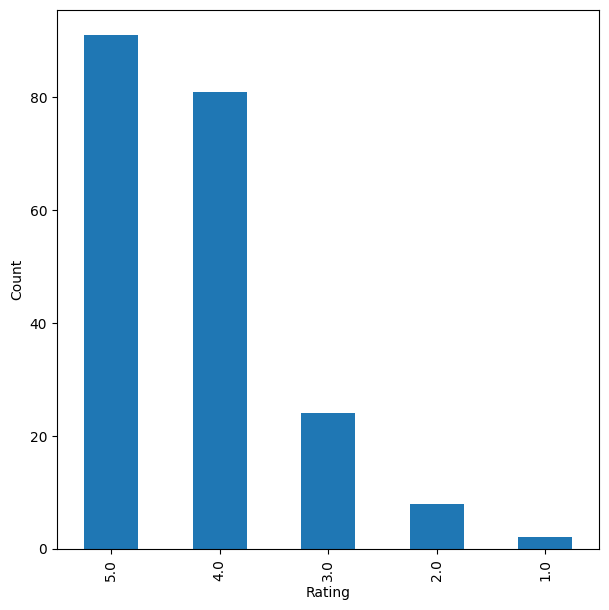

In [34]:
# Plot distributions for the most rated product

plt.figure(figsize=(7,7))

df_final[df_final['prod_id'] == 'B0088CJT4U']['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')
plt.show()

Observations: Pretty high ratings for product B0088CJT4U. This product has mostly 5 and 4 value ratings in the observations.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

Observations: We are going to build a recommendation system based on the average rating for each product.

In [35]:
# Calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

final_rating.head()


,avg_rating,rating_count
prod_id,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5


In [36]:
# Let's first see the top 10 ratings byt the product
top_10 = final_rating.head(10)

top_10

,avg_rating,rating_count
prod_id,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5
B00000J1V5,4.571429,7
B00000JDF5,4.714286,7
B00000JDF6,4.571429,7
B00000K135,4.800000,5


In [39]:
# Sort the dataframe by average of ratings in the descending order
sorted_df = final_rating.sort_values(by='avg_rating', ascending=False)
sorted_df

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.000000,5
B003DZJQQI,5.000000,14
B005FDXF2C,5.000000,7
B00I6CVPVC,5.000000,7
B00B9KOCYA,5.000000,8
...,...,...
B003O2RVGM,1.833333,12
B000ND75C0,1.833333,6
B007C0Y7RI,1.625000,8


In [42]:
# See the first five records of the "final_rating" dataset
top_5 = final_rating.head(5)
top_5

,avg_rating,rating_count
prod_id,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5


In [43]:
# Here we also see the top 5 records from our final data set, but considering the sorted data in descending order, so here are the top 5
# with highest rating
topi_5 = sorted_df.head(5)
topi_5

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [44]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(data, n, min_interaction=100):

    # Finding products with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]

    # Sorting values with average rating in the descending order
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)

    return recommendations.index[:n]




In [64]:
# Finding products with minimum number of interactions (top 5 products)
minimum_interactions = list(top_n_products(final_rating, 5, 1))

print('Top 5 Producst with Minimum interactions:')
print(minimum_interactions)


Top 5 Producst with Minimum interactions:
['B00LGQ6HL8', 'B003DZJQQI', 'B005FDXF2C', 'B00I6CVPVC', 'B00B9KOCYA']


In [81]:
# Sorting values with respect to average rating with 100 interactions
average = list(top_n_products(final_rating, 5, 100))
average

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [86]:
res = list(top_n_products(final_rating, 5, 50))
print('Top 5 products with 50 minimum interactions')
print(res)

Top 5 products with 50 minimum interactions
['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [87]:
res2 = list(top_n_products(final_rating, 5, 50))
print('Top 5 products with 100 minimum interactions')
print(res2)

Top 5 products with 100 minimum interactions
['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [88]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [89]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

In [99]:
from sklearn.preprocessing import LabelEncoder
data=df_final[['user_id','prod_id']].apply(LabelEncoder().fit_transform)
data['rating']=df_final['rating']
data.head(100)


,user_id,prod_id,rating
1309,1050,0,5.0
1321,125,0,1.0
1334,785,0,3.0
1450,1495,0,5.0
1455,164,0,1.0
...,...,...,...
23740,1210,12,3.0
23782,711,12,5.0
23875,819,12,5.0
23935,179,12,4.0


In [100]:
# Creating a copy of the above dataset for further use
df_rating = data.copy()

In [101]:
# Calculating average ratings
average_rating = data.groupby('prod_id').mean()['rating']

# Calculating the count of ratings
count_rating = data.groupby('prod_id').count()['rating']

# Updating the final_rating dataframe with the new encoded book_id count and average of ratings based on the new dataframe
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})
final_rating.head()

,avg_rating,rating_count
prod_id,,
0,3.333333,6
1,3.833333,6
2,4.000000,5
3,4.875000,8
4,5.000000,5


Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [102]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 10))

# Loading the rating dataset
data = Dataset.load_from_df(data[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.3, random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [103]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
algo_knn_user = KNNBasic(sim_options=sim_options,verbose=False)

# Fit the model on the training data
algo_knn_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(algo_knn_user)



RMSE: 1.0250
Precision:  0.86
Recall:  0.783
F_1 score:  0.82


**Write your observations here:**

1.- On our base model we have a Root Mean Square Error is 1.025 in our test set.

2.- The precision shows us that out of all our recommended products we 86% are relevant which looks good.

3.- Our recal of 78.3% is not too great since just of 78.3% of the relevant books are recommended, so we are missing other books that we should be recomending. But it's not terrible since we are close to the 80% which would be a good metric.

F_1 Score is 82% which is also telling us our model is good since 82% of the books we recommend are relevant.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [104]:
# Predicting rating for a sample user with an interacted product
algo_knn_user.predict('A3LDPF5FMB782Z', 1400501466, r_ui=5, verbose=True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here:**

With a given rating of 5, we obtain a predicted rating of 4.29 which is tolerable I think.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [110]:
# Find unique user_id where prod_id is not equal to "1400501466"

# Filter the DataFrame to select rows where prod_id is not equal to "1400501466"
filtered_df = df_final[df_final['prod_id'] != "1400501466"]

# Find unique user IDs in the filtered DataFrame
unique_user_ids = filtered_df['user_id'].unique()

userlookingfor = unique_user_ids == 'A34BZM6S9L7QI4'
# Print the unique user IDs
print("Unique user IDs where prod_id is not equal to '1400501466':")
print(userlookingfor)

Unique user IDs where prod_id is not equal to '1400501466':
[False False False ... False False False]


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [114]:
# Predicting rating for a sample user with a non interacted product
algo_knn_user.predict('A34BZM6S9L7QI4', 1400501466, verbose=True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here:**
We get an estimated rate of 4.29 which is not too bad on predicting the rating for a user that hasn't interact with that book.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [115]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }


# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)


# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])


# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9714743926179926
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [116]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}


# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized = KNNBasic(sim_options=sim_options, k=40, min_k=6, verbose=False)


# Training the algorithm on the train set
similarity_algo_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(similarity_algo_optimized)


RMSE: 0.9630
Precision:  0.85
Recall:  0.809
F_1 score:  0.829


**Write your observations here:**

Values before tunning:

RMSE: 1.0250

Precision:  0.86

Recall:  0.783

F_1 score:  0.82

After tunning, RMSE decreased .062 (it came from 1.0250   to 0.9630).

Precision stayed almost same (decreased just .01)
Recall improved 0.026 (from 0.783 to 0.809)

F_1 Score keeps aceptable, over 80%



### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [117]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
similarity_algo_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [118]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
similarity_algo_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here:**
The model after tunning shows the same results, predicting a rate of 4.29 which is not too far from the actual predicted value of 5.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [119]:
# 0 is the inner id of the above user
similarity_algo_optimized.get_neighbors(0, k=5)


[7, 12, 16, 17, 26]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [120]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

In [121]:
# Eliminate duplicates
df_rating=df_rating.drop_duplicates()

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [134]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, similarity_algo_optimized)
recommendations

[('1400532655', 4.291403190162572),
 ('1400599997', 4.291403190162572),
 ('9983891212', 4.291403190162572),
 ('B00000DM9W', 4.291403190162572),
 ('B00000J1V5', 4.291403190162572)]

Observations: I am calling df_final data set, not df_rating since df_rating is encoded and can not find the user  "A3LDPF5FMB782Z" there, but as I understands, this will not change my prediction.

In [135]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])


,prod_id,predicted_ratings
0,1400532655,4.291403
1,1400599997,4.291403
2,9983891212,4.291403
3,B00000DM9W,4.291403
4,B00000J1V5,4.291403


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [139]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items. Use random_state=1
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset, and predict ratings for the test set
algo_knn_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(algo_knn_item)


RMSE: 1.0232
Precision:  0.835
Recall:  0.758
F_1 score:  0.795


**Write your observations here:**

Recall is below 80%, and having a F_1 score of 0.795 and RSME we can try to do some tunning to improve our model.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [141]:
# Predicting rating for a sample user with an interacted product
algo_knn_item.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here:**

We have same estimated rating from the past models using this user and product_id.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [142]:
# Predicting rating for a sample user with a non interacted product
algo_knn_item.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here:**

Estimated value continues the same from past models. Estimated value of rating keeps being 4.29

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [143]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10,20,30], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }


# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)


# Fitting the data
grid_obj.fit(data)


# Find the best RMSE score
print(grid_obj.best_score['rmse'])


# Find the combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [144]:
# Using the optimal similarity measure for item-item based collaborative filtering

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options={'name': 'msd', 'user_based': False}, k=30, min_k=6,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(similarity_algo_optimized_item)


RMSE: 0.9694
Precision:  0.836
Recall:  0.797
F_1 score:  0.816


**Write your observations here:**
Our last values before this last tunning with GridSearchCV:
RMSE: 1.0232
Precision:  0.835
Recall:  0.758
F_1 score:  0.795

We have a nice improvement. now F_1 score is over 80% (F_1 = 0.816).

Precision remained almost the same (improved  0.01) and Recall went up 0.04, getting really close to the 80%.

This model seems good afterall!



### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [145]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
similarity_algo_optimized_item.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [146]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
similarity_algo_optimized_item.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Write your observations here:**

Eventhough our model improved the metrics of precision, recall and F_1, our model is predicting and estimated rating pretty much the same as the one of the other models and before tunning. Predicted rating is 4.29. which is pretty good.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [147]:
similarity_algo_optimized_item.get_neighbors(0, k=5)

[53, 67, 106, 151, 156]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [150]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final,'A1A5KUIIIHFF4U', 5, similarity_algo_optimized_item)
recommendations

[('1400532655', 4.291403190162572),
 ('1400599997', 4.291403190162572),
 ('9983891212', 4.291403190162572),
 ('B00000DM9W', 4.291403190162572),
 ('B00000J1V5', 4.291403190162572)]

In [151]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])


,prod_id,predicted_ratings
0,1400532655,4.291403
1,1400599997,4.291403
2,9983891212,4.291403
3,B00000DM9W,4.291403
4,B00000J1V5,4.291403


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [152]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)


RMSE: 0.8995
Precision:  0.86
Recall:  0.797
F_1 score:  0.827


**Write your observations here:**

Item-items similarity based values:
RMSE: 0.9694
Precision:  0.836
Recall:  0.797
F_1 score:  0.816

User-user similarity based values:
RMSE: 0.9630
Precision:  0.85
Recall:  0.809
F_1 score:  0.829

With SVD (Similar Value Decomposition):
RMSE: 0.8995
Precision:  0.86
Recall:  0.797
F_1 score:  0.827

We see the precision is higher with SVD compared to item-iteam and user-user models.

Recall with SVD is the same as with item-item, and the best value in recall is from user-user model.

F_1 score with user-user is the highest, but after that SVD is just about .002 below that.

RMSE on SVD is quite below from the other two models.

So, we could say that the performance of user-user model is better than the other two models.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [154]:
# Making prediction
svd.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.291403190162572, details={'was_impossible': False})

**Write your observations here:**
Estimated rating keeps the same as our past models, with a value of 4.29

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [155]:
# Making prediction
svd.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': False})

**Write your observations here:**

Estimated rating keeps the same as our past models, with a value of 4.29

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [156]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)


# Fitting data
gs_.fit(data)


# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])


0.8978433237257706
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [157]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2, random_state=1)


# Train the algorithm on the trainset
svd_optimized=svd_optimized.fit(trainset)


# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)



RMSE: 0.8903
Precision:  0.862
Recall:  0.796
F_1 score:  0.828


**Write your observations here:**
Values before tunning:
RMSE: 0.8995
Precision:  0.86
Recall:  0.797
F_1 score:  0.827

We see the performance is pretty much the same with the parameters used. Other parameters could give an improvement in case we were curious to explore towards this.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [158]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.291403190162572, details={'was_impossible': False})

In [159]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': False})

### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**

In this project we analyzed a dataset from Amazon featuring products, users and ratings for the products.
First, we observed the dataset, the dimension, statistics and distributions. We decreased the size of our dataset based on taking users that were given at least 50 ratings and products that have at least 5 ratings.
We built recommendation systems to recommend products based on ratings.

The models we worked with were:

MODEL 1:  Rank Based Recommendation System.
We recommended the top 5 products based on popularity, with minimum of 50 and 100 iteractions.

MODEL 2: Collaborative Filtering, using cosine similarity (our dataset is sparce) and KNN algorithm.

With user-user mode our results were:
RMSE: 1.0250
Precision:  0.86
Recall:  0.783
F_1 score:  0.82

When look for an specific user the estimated rating was 4.29 (same for when we improved the parameters).

With improved parameters:

RMSE: 0.9630
Precision:  0.85
Recall:  0.809
F_1 score:  0.829


With Item-item  MODE:
RMSE: 1.0232
Precision:  0.835
Recall:  0.758
F_1 score:  0.795

After tunning with GridSearchCV:
RMSE: 0.9694
Precision:  0.836
Recall:  0.797
F_1 score:  0.816


When predicting for an specific user, estimated rating was 4.29

MODEL 3: Model Based Collaborative Filtering -Matrix Factorization, using SVD.

RMSE: 0.8995
Precision:  0.86
Recall:  0.797
F_1 score:  0.827

Estimated rating for an specific user still 4.29

After improving SVD:
RMSE: 0.8903
Precision:  0.862
Recall:  0.796
F_1 score:  0.828


As a last conclusion, after comparing all the models on each part of the process, RMSE, precision, recall, F_1 score but also the estimated ratings for specific values, I found that the model 2, Collaborative Filtering with user-user mode give us the best number on precision, recall, F_1 score and RMSE.

This project has been really great to see the different ways we can predict best products to clients based on all the different models we can use.





